# Lab: Aprendizaje por refuerzo (II)
# 6 - Q-Learning (II)

## Configuración y dependencias

In [1]:
# Declaración de constantes
SLIPPERY = False
NUM_EPISODES = 200
GAMMA = 0.99
LEARNING_RATE = 0.01
EPSILON = 0.2
T_MAX = 50

In [2]:
!pip install gymnasium seaborn numpy pygame

import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import abc
import numpy as np
import random

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 91.6 MB/s eta 0:00:0000:0100:01


In [3]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=SLIPPERY)

def draw_history(history, title):
    window_size = 50
    data = pd.DataFrame({'Episode': range(1, len(history) + 1), title: history})
    data['rolling_avg'] = data[title].rolling(window_size).mean()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y=title, data=data)
    sns.lineplot(x='Episode', y='rolling_avg', data=data)

    plt.title(title + ' Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel(title)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

En este notebook, vamos a ver una implementación alternativa de Q-Learning que guarda algunas similaridades con la implementación básica con una matriz (de estados por acciones) pero que aplica algunas optimizaciones típicas que se suelen ver en las implementaciones de este algoritmo.

En este caso vamos a tener una estructura (llamada `weights`) de tamaño (estados + 1) por acciones. Cada uno de estos valores representa un peso dentro de una ecuación lineal. ¿Por qué un elemento más que el número de estados? Porque vamos a utilizar este elemento extra de una manera similar al "intercept" de una regresión lineal (como la `b` de `y = ax + b`). 

**La b en vez de ser un offset es un vector de pesos, uno por cada dimension.**

Para representar el estado, vamos a usar un vector con todas las posiciones a 0 menos la que corresponde a ese estado. Este tipo de vector se suele denominar "one hot". Por ejemplo, si el estado es el 0, su vector one hot será el `[1 0 0 .. 0]`, si el estado es el 1, su vector será `[0 1 0 .. 0]`, y así sucesivamente. Esto nos permite hacer las actualizaciones de la función Q como multiplicaciones de matrices y vectores.

Los nuevos pesos de un estado dependerán de la función de actualización según el algoritmo de diferencias temporales. En el fondo, esta implementación es equivalente a la que vimos en el notebook 4 pero, como veremos en el siguiente notebook, nos va a permitir más flexibilidad.

In [4]:
class LinearApproximationAgent(metaclass=abc.ABCMeta):
    def __init__(self, state_dimensions, action_space, learning_rate, discount_factor, epsilon, seed):
        self.weights = np.zeros((state_dimensions + 1, action_space))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_space = action_space
        self.rng = random.Random(seed)

    def select_action(self, state, training=True):
        if training and self.rng.random() < self.epsilon:
            return self.rng.choice(range(self.action_space))
        features = self.extract_features(state)
        q_values = np.dot(features, self.weights)
        return np.argmax(q_values)

    def update_weights(self, state, action, reward, next_state, done):
        features = self.extract_features(state)
        next_features = self.extract_features(next_state)
        q_values_next = np.dot(next_features, self.weights)
        best_next_action = np.argmax(q_values_next)
        td_target = reward + self.discount_factor * q_values_next[best_next_action] * (not done)
        td_error = td_target - np.dot(features, self.weights[:,action])
        self.weights[:,action] += self.learning_rate * td_error * features
        return td_error

    @abc.abstractmethod
    def extract_features(self, state):
        pass

Hemos dejado la función `extract_features` vacía, porque ahora haremos una reimplementación y luego haremos otra en un notebook posterior. De momento, lo importante es tener en cuenta que esta función ha de retornar la representación (o el conjunto de características o _features_) del estado.

Para el caso que nos ocupa, en el que tenemos estados claramente definidos con valores discretos entre 0 y 15, basta con definir un vector one hot para este estado:

In [5]:
class DiscreteStateLinearApproximationAgent(LinearApproximationAgent):
    def __init__(self, state_dimensions, action_space, learning_rate=0.01, discount_factor=0.99,
                 epsilon=0.2, seed=42):
        super().__init__(state_dimensions, action_space, learning_rate, discount_factor, epsilon, seed)
        self.max_states = state_dimensions

    def one_hot_encode(self, idx):
        arr = np.zeros(self.max_states)
        arr[idx] = 1
        return arr

    def extract_features(self, state):
        return np.append(self.one_hot_encode(state), 1)

Definimos la función de entrenamiento en base a esta implementación, recogiendo el valor de la pérdida (que en TD se define como el error o valor de la función de actualización).

In [9]:
def train_agent(agent, environment):
    rewards = []
    losses = []
    for episode in range(20000):
        state, _ = environment.reset()
        done = False
        total_reward = 0
        sum_losses = 0
        steps = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, terminated, _ = environment.step(action)
            sum_losses = sum_losses + agent.update_weights(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps = steps + 1
        losses.append(sum_losses / steps)
        rewards.append(total_reward)
    draw_history(rewards, 'Reward')
    draw_history(losses, 'Loss')

Usad el siguiente código para entrenar. Os dará la impresión de que no entrena, pero dadle una oportunidad. **Probad con un número más grande de episodios.**

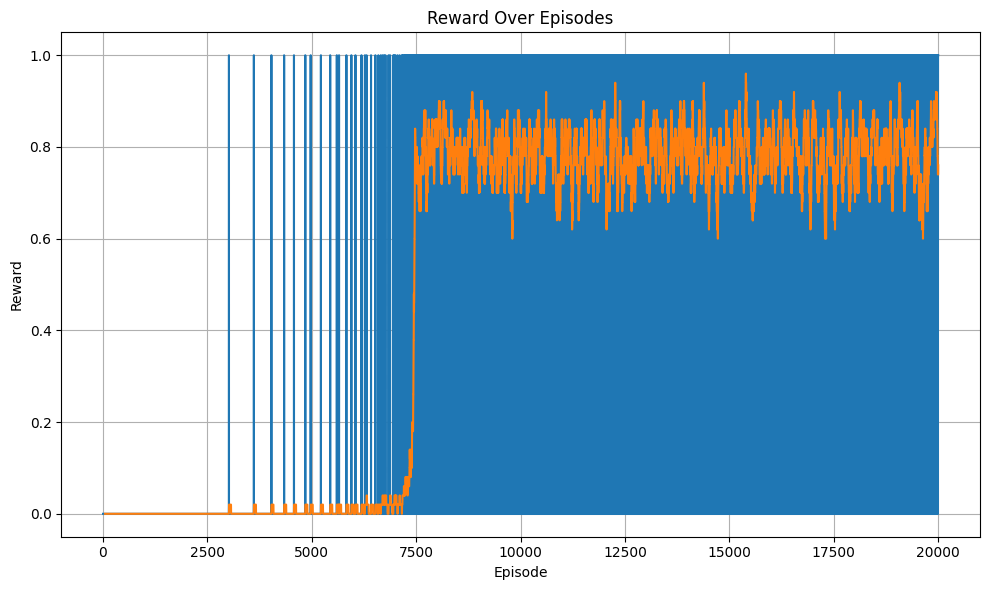

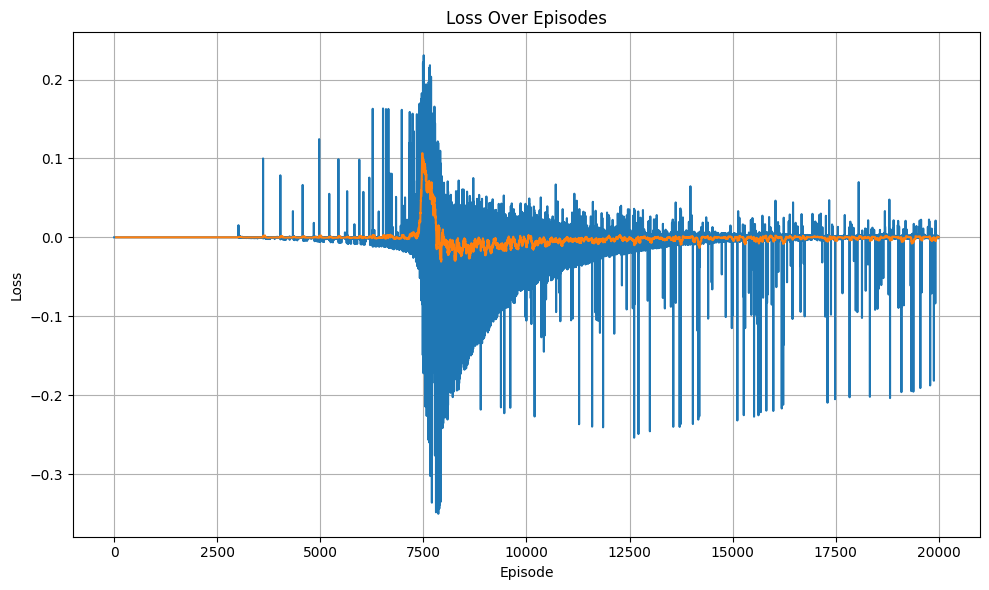

In [11]:
def train_frozen_lake_td0_linear_approx(environment):
    agent = DiscreteStateLinearApproximationAgent(16, 4)
    train_agent(agent, environment)
    return agent

agent = train_frozen_lake_td0_linear_approx(env)

Podemos ver que al principio esta aprendiendo, hasta que en la iteracion 7500 encuentra la solucion, despues hace pequeños ajustes para encontrar la politica optima (linea narajna).

Una vez ya hemos encontrado una solucion valida, queremos reducir al maximo la varianza (grafica azul). Uno de los problemas de REINFORCE, es hasta que punto vale la pena entrenar el modelo.

**¿Cómo interpretáis las gráficas de recompensa y pérdida?**

Evaluemos el agente que hemos obtenido:

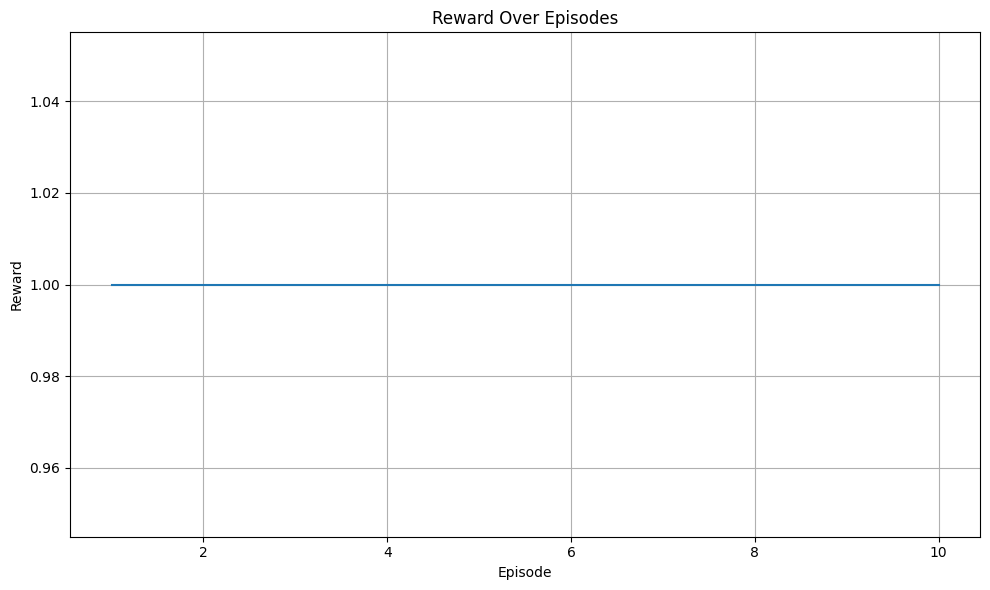

In [13]:
def evaluate_agent(agent, environment):
    episodes = 10
    rewards = []
    for episode in range(episodes):
        state, _ = environment.reset()
        done = False
        total_reward = 0
        step = 0
        while not done and step < T_MAX:
            action = agent.select_action(state, training=False)
            state, reward, done, terminated, _ = environment.step(action)
            total_reward += reward
            step = step + 1
        rewards.append(total_reward)
    draw_history(rewards, 'Reward')
evaluate_agent(agent, env)

Parece que la política es óptima. Vamos a comprobarlo mirando la estructura `weights`. Cada fila representa los pesos de cada estado: un peso para cada acción. La última fila tiene el "intercept", también llamado sesgo o "bias". Es un valor a sumar a cada peso de la misma columna, como en una regresión lineal.

In [14]:
agent.weights

array([[ 0.16715093,  0.25133721,  0.33835021,  0.21423577],
       [ 0.16638871, -0.33164179,  0.06813867,  0.07381588],
       [ 0.08211979,  0.03682936, -0.03295101,  0.01534908],
       [ 0.02900689, -0.05549144, -0.05207083,  0.02456437],
       [ 0.17585655,  0.26087659, -0.58497488,  0.21466994],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.28079641,  0.27724405, -0.16669002,  0.04772971],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.18484688, -0.70028137,  0.38471713,  0.22457741],
       [ 0.18436442,  0.27543423,  0.39462136, -0.72398514],
       [ 0.1931767 ,  0.29048732, -0.583905  ,  0.23989126],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.33567572,  0.10735257,  0.40455978,  0.14429715],
       [ 0.20334556,  0.28718655,  0.41511489,  0.25416056],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.7697843 ,  0.

La ultima linea es la b de la ecuacion, mientras que las otras filas son la a para las diferentes dimensiones. Si lo sumamos todo son casi equiprobables

Para obtener la política, hemos de seleccionar las acciones en modo inferencia (es decir, no en modo entrenamiento) para que no sea estocástica. Esto equivale a escoger el valor máximo de peso + sesgo para cada estado:

In [15]:
def policy(agent: DiscreteStateLinearApproximationAgent):
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        policy[s] = agent.select_action(s, training=False)
    return policy

def print_policy(policy):
    visual_help = {0:'<', 1:'v', 2:'>', 3:'^'}
    policy_arrows = [visual_help[x] for x in policy]
    print(np.array(policy_arrows).reshape([-1, 4]))

print_policy(policy(agent))

[['v' '<' '<' '<']
 ['v' '<' 'v' '<']
 ['>' '>' 'v' '<']
 ['<' '>' '>' '<']]


Por curiosidad, vamos a comprobar el rendimiento con `slippery=True`:

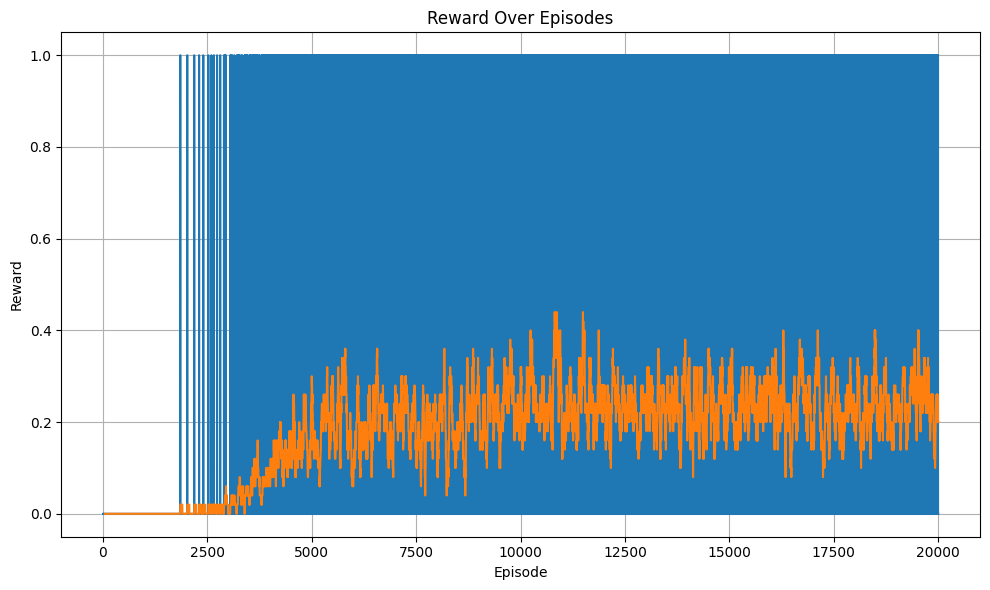

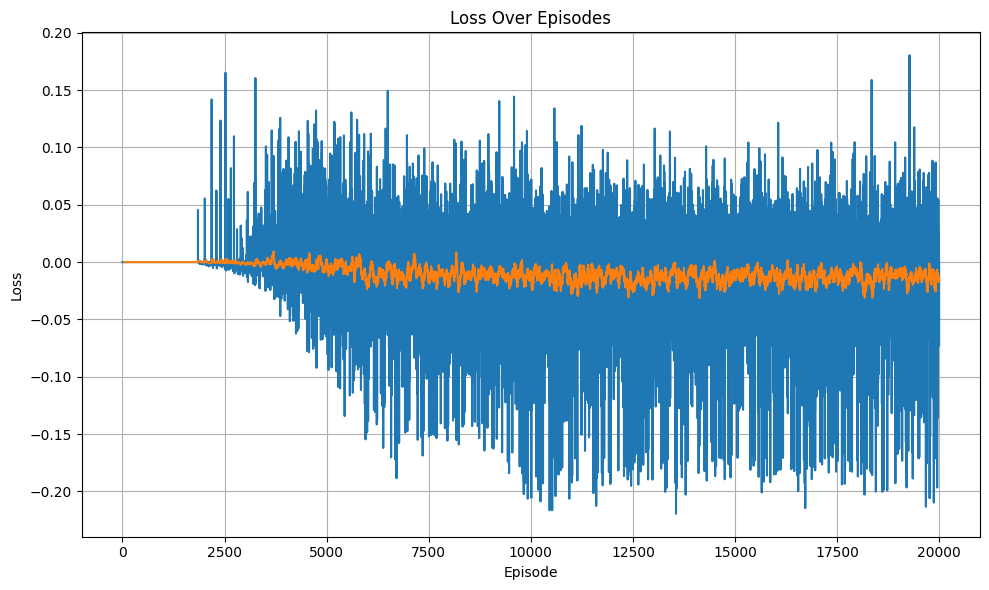

In [16]:
env_slippery = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True)
agent_slippery = train_frozen_lake_td0_linear_approx(env_slippery)

Vamos a evaluar la política obtenida. Recordad que el entorno ahora es estocástico, por lo que incluso con una política óptima el éxito no está asegurado:

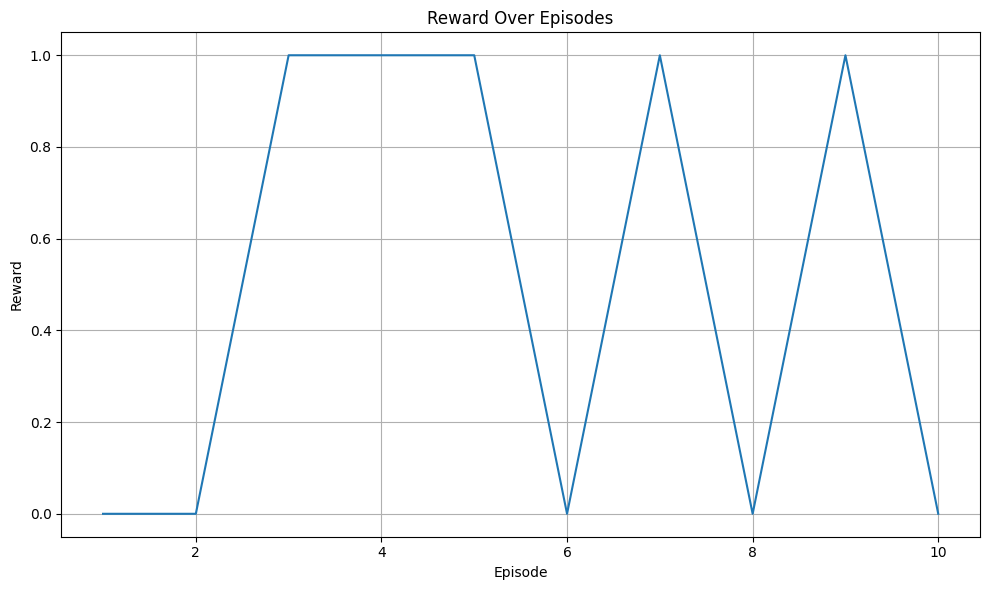

In [17]:
evaluate_agent(agent_slippery, env_slippery)

¿Crees que el resultado es bueno?

No es bueno porque una vez mas la politica no es la correcta para el slippery. Una vez mas en la casilla [1,0] deberia ser <, en vez de v.

Vamos a revisar la política:

In [18]:
print_policy(policy(agent))

[['v' '<' '<' '<']
 ['v' '<' 'v' '<']
 ['>' '>' 'v' '<']
 ['<' '>' '>' '<']]


El problema es que el sistema de ecuaciones no es lineal para el caso slippery.